# PGCs and MYC samples trajectories with DPT

In [1]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb

import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri

In [2]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()

scanpy==1.4.4.post1 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.3 scipy==1.3.0 pandas==0.24.2 scikit-learn==0.21.2 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


In [3]:
sc.set_figure_params(dpi_save=320,format='tiff')
sc.settings.autosave=True

In [4]:
results_file = './write/PGCs_MYC_ICtrajectory.h5ad'

In [25]:
%%R
# Load all the R libraries we will be using in the notebook
library(scran)

### Read PGCs and MYC-IC data

In [5]:
rds_path = '../../../../scRNAseq_Ranalysis/Seurat_v3/trajectories/PGCs/'

In [12]:
%%R -i rds_path -o pgc_marioni -o pgc_cao -o myc

pgc_marioni = readRDS(paste0(rds_path,'pgc_marioni_py.rds'))
pgc_cao = readRDS(paste0(rds_path, 'pgc_cao_py.rds'))
myc = readRDS(paste0(rds_path,'MYC_IC_py.rds'))

In [13]:
# Concatenate to unique adata object
adata = pgc_marioni.concatenate([pgc_cao, myc], batch_key='batch',
                                                        index_unique=None)

In [15]:
adata

AnnData object with n_obs × n_vars = 1803 × 17470 
    obs: 'CellType', 'Cluster', 'Main_trajectory', 'Size_Factor', 'Sub_trajectory_name', 'Total_mRNAs', 'Trajectory', 'all_exon', 'all_intron', 'all_reads', 'batch', 'cell', 'celltype', 'day', 'extraction_date', 'id', 'ident', 'integrated_snn_res.0.5', 'localization', 'louvain_component', 'nCount_RNA', 'nFeature_RNA', 'new_clustering', 'num_genes_expressed', 'orig.ident', 'percent.mt', 'sample', 'sequencing.batch', 'seurat_clusters', 'sex', 'stage', 'sub_Cluster', 'sub_cluster_id', 'sub_tsne_1', 'sub_tsne_2', 'subgroup', 'tsne_1', 'tsne_2', 'unmatched_rate'
    var: 'vst.mean-1', 'vst.variance-1', 'vst.variance.expected-1', 'vst.variance.standardized-1', 'vst.variable-1'
    layers: 'logcounts'

In [14]:
adata.obs.head()

,CellType,Cluster,Main_trajectory,Size_Factor,Sub_trajectory_name,Total_mRNAs,Trajectory,all_exon,all_intron,all_reads,...,sex,stage,sub_Cluster,sub_cluster_id,sub_tsne_1,sub_tsne_2,subgroup,tsne_1,tsne_2,unmatched_rate
cell_394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,E7.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cell_477,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,E7.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cell_717,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,E7.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cell_745,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,E7.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cell_1005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,E7.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Normalization

In [20]:
# Exclude genes that are = 0 in all cells
#Filter genes:
print('Total number of genes: {:d}'.format(adata.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=20)
print('Number of genes after cell filter: {:d}'.format(adata.n_vars))

Total number of genes: 17470
filtered out 5269 genes that are detectedin less than 20 cells
Number of genes after cell filter: 12201


In [21]:
#Perform a clustering for scran normalization in clusters
adata_pp = adata.copy()
sc.pp.normalize_per_cell(adata_pp, counts_per_cell_after=1e6)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15, svd_solver='arpack')
sc.pp.neighbors(adata_pp)
sc.tl.louvain(adata_pp, key_added='groups', resolution=0.5)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
computing PCA with n_comps = 15
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 15
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:02)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 9 clusters and added
    'groups', the cluster labels (adata.obs, categorical) (0:00:00)


In [22]:
# Check if the minimum number of cells per cluster is < 21:in that case, sizes will be also passed as input to the normalization
adata_pp.obs['groups'].value_counts()

0    397
1    392
2    243
3    201
4    169
5    161
6    118
7     74
8     48
Name: groups, dtype: int64

In [23]:
#Preprocess variables for scran normalization
input_groups = adata_pp.obs['groups']
data_mat = adata.X.T

In [26]:
%%R -i data_mat -i input_groups -o size_factors

size_factors = computeSumFactors(data_mat, clusters=input_groups, min.mean=0.1)

In [27]:
#Delete adata_pp
del adata_pp

In [31]:
# Visualize the estimated size factors
adata.obs['size_factors'] = size_factors

#Keep the count data in a counts layer
adata.layers["counts"] = adata.X.copy()

#Normalize adata 
adata.X /= adata.obs['size_factors'].values[:,None]
sc.pp.log1p(adata)

### Use BBKNN to correct for batch effects

In [33]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA with n_comps = 50
    finished (0:00:03)


In [34]:
sc.external.pp.bbknn(adata, batch_key='batch')

computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
	'distances', weighted adjacency matrix
	'connectivities', weighted adjacency matrix (0:00:02)


In [35]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:04)


In [36]:
sc.tl.diffmap(adata)

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [0.9999895  0.9246844  0.9157605  0.90985906 0.9050888  0.9007142
     0.8952182  0.89182764 0.8884037  0.8844446  0.8834754  0.8808854
     0.87787074 0.8763907  0.875248  ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)


In [38]:
adata.obs['batch'] = adata.obs['batch'].astype('category')

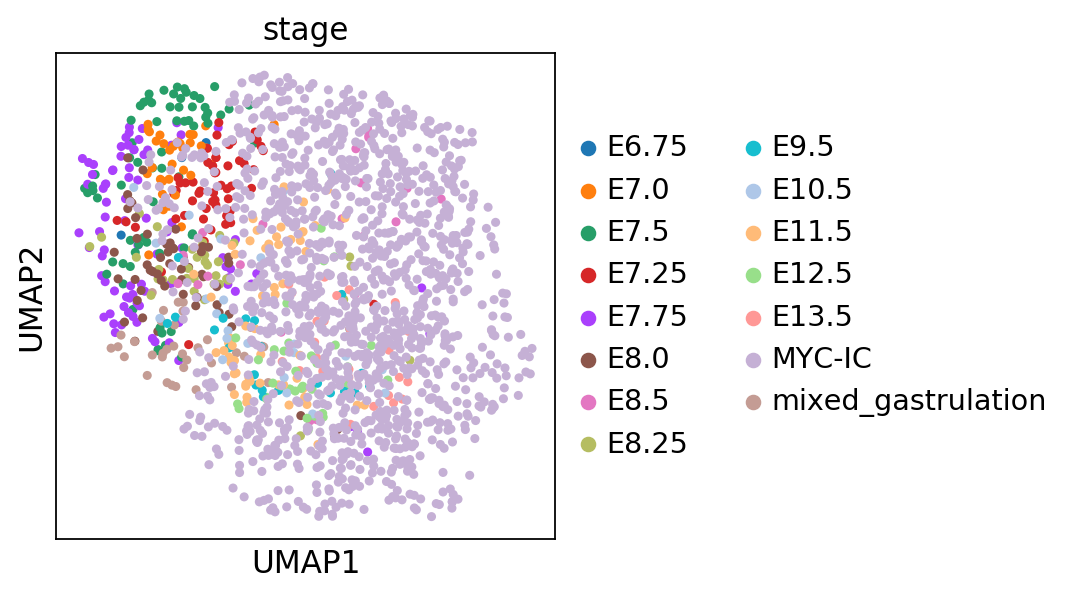

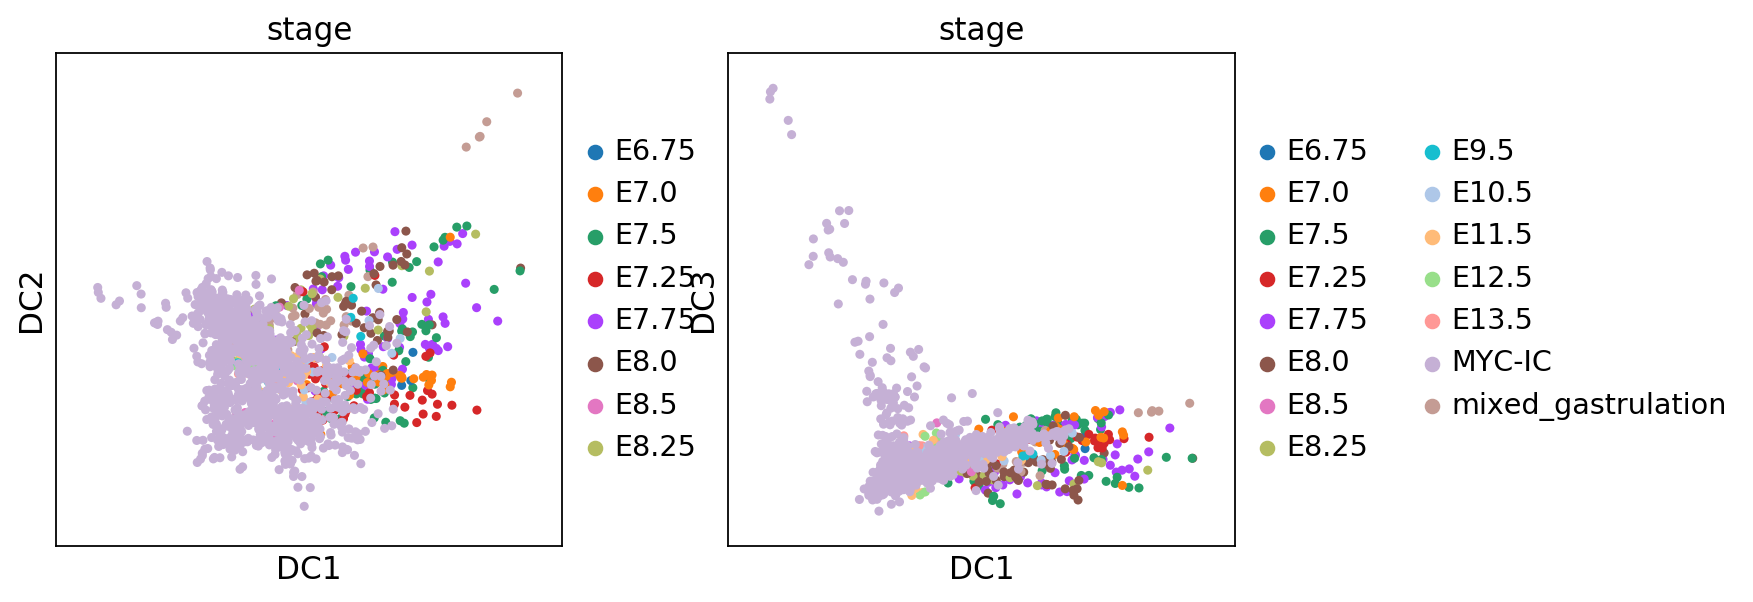

In [47]:
sc.pl.umap(adata, color = 'stage', save = '_pgc_mycic_stage')
sc.pl.diffmap(adata, components=['1,2','1,3'], color='stage', save = '_pgc_mycic_stage')

In [42]:
# Calculate pseudotime with DPT
adata.uns['iroot'] = np.flatnonzero(adata.obs['stage'] == 'E6.75')[0]
sc.tl.dpt(adata, n_branchings=1, n_dcs=15)

computing Diffusion Pseudotime using n_dcs=15
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs)
    'dpt_groups', the branching subgroups of dpt (adata.obs)
    'dpt_order', cell order (adata.obs) (0:00:00)


/opt/conda/lib/python3.7/site-packages/scipy/sparse/lil.py:504: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not i.flags.writeable or i.dtype not in (np.int32, np.int64):
/opt/conda/lib/python3.7/site-packages/scipy/sparse/lil.py:506: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not j.flags.writeable or j.dtype not in (np.int32, np.int64):


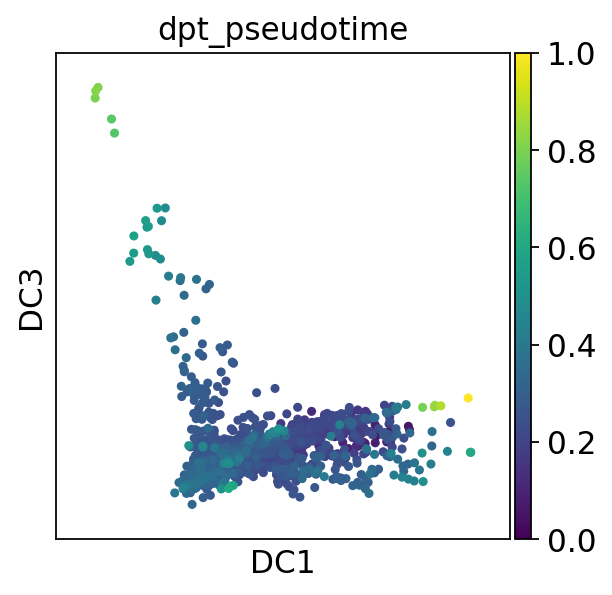

In [52]:
sc.pl.diffmap(adata, components='1,3', color='dpt_pseudotime', save = '_pgc_mycic_dpt')

In [51]:
# save final result
adata.write(results_file)